<a href="https://colab.research.google.com/github/pfescriva/Applied-AI-for-Business-Insight/blob/main/TFM_Pere_26.8.16h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Code to load libraries:

# !pip install mglearn
# !pip install gensim
# !pip install stop_words
# !pip install pyLDAvis
# !pip install langdetect
# !pip install unidecode
# !pip install indexer
# !pip install spellchecker

from spellchecker import SpellChecker
import sklearn as sk
import pandas as pd 
import numpy as np 
import mglearn
from stop_words import get_stop_words
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
import warnings
from gensim.utils import simple_preprocess
from gensim import utils 
from collections import Counter
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from langdetect import detect
import spacy
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
!pip install spellchecker

In [4]:

# path = '/content/drive/MyDrive/TFM data/urjc.jsonl.gz'
# data = pd.read_json(path, lines = True)


In [5]:

# # 0. Some initial cleaning (Empty cols and constant cols)
# data.dropna(how = 'all', axis = 1, inplace = True) # Drop empty columns
# data = data.loc[:, (data != data.iloc[0]).any()]  # Drop Constant columns
# print(data.shape[0])

# # Filter out non-spanish documents
# data = data.loc[(data['lang'] == "es")].reset_index(drop  = True)
# print('First lang filter: ' + str(data.shape[0]))

# # Filter out non-spanish documents with higher precission.
# data['Language'] = data['text'].apply(detect)
# data = data.loc[(data['Language'] == "es")].reset_index(drop  = True)
# print('First lang filter: ' + str(data.shape[0]))

# # Keep only non RT information
# data = data.loc[ ~ (data['text'].str.startswith('RT '))]
# print('RT removal: ' + str(data.shape[0]))

# # 1. Drop duplicated documents that are writen by the same user, and laso drop any tweet that is NA (There were not anyway)
# data = data.drop_duplicates(subset = ['author_id', 'text'], keep = 'first', inplace = False, ignore_index = False).reset_index(drop = True)
# data = data.dropna(subset = ['text'])
# print('Dropped duplicates and empty texts: ' + str(data.shape[0]))



171294
First lang filter: 162192
First lang filter: 157279
RT removal: 38361
Dropped duplicates and empty texts: 38261


In [6]:

# data.to_pickle("/content/drive/MyDrive/TFM data/clean_data_colab.pkl")


In [7]:
# data = pd.read_pickle("/content/drive/MyDrive/TFM data/clean_data.pkl")
data = data[data['in_reply_to_user_id'].isnull()]

In [8]:

import os
os.getcwd()


'/content'

In [ ]:

"""

PRE-PROCESS: 

0. Get the unduplicated / non-retweeted tweets. 


NON-TUNED PRE-PROCESSING STEPS:

1. Remove the hashtags, links and shares

2. Lowcase 

3. Remove punctuation 

4. Remove accents 

5. Remove numbers (TBC)

6. Lemmatise 

7. Make some corrections uncovered above


TUNED STEPS:

8. Remove stopwords (TBC properly) 

9. Remove short tweets 

10. Group by author and gridsearch best LDA hyperparameters.  

"""


import warnings
warnings.filterwarnings("ignore")


# 1. Remove links, hashtags and mentions
# --------------------------------------

def hashtag(txt):
    
    # Remove hashtags
    result = ' '.join(word for word in txt.split(' ') if not word.startswith('#'))
    
    # Remove shares
    result = ' '.join(word for word in result.split(' ') if not word.startswith('@'))
    # check if this doesn't work well use: result = re.sub(r'@\S+', '', result)
        
    # Remove some jajajas
    result = ' '.join(word for word in result.split(' ') if 'jaja' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'jj' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'haha' not in word.lower())

    # Remove links
    result = re.sub(r'http\S+', '', result)

    # Further work with potential remainings
    result = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", result)
    result = re.sub(r'[¿“‘?’"„“<>,!"]', "", result)
    result = re.sub('!', "", result)
    
    return result

    
data['text'] = data['text'].apply(hashtag)


# 2. Lowcase and make corrections
# --------------------------------------

data['text'] = data['text'].apply(np.char.lower)



# 3. Remove punctuation from text
# --------------------------------------

from gensim.parsing.preprocessing import strip_punctuation
data['text'] = data['text'].apply(strip_punctuation)



# 4. Correct some misspallings and Remove accents from text
# --------------------------------------


# It take some time: 200 rows per minute 

def correction(x): 

    spanish = SpellChecker(language = 'es')  # use the Spanish Dictionary
    
    """
    correction(x) process: 
    1. Convert string into list of words
    2. Apply the most likely correction of each word
    3. Convert the list back to a string
    """
    
    x = x.split()
    x = [spanish.correction(word) for word in x]
    x = ' '.join([word for word in x])
    
    return x

data['correction'] = data['text'].apply(correction)
 



# 5. Remove numbers
# --------------------------------------

data['text'] = data['text'].str.replace('\d+', '')



# 6. Further cleaning before lemmatisation
# --------------------------------------

def corrector(text):     
    text = text.replace(' lumnos ', ' alumno ') 
    text = text.replace(' estudiante ', ' alumno ') # Synonims I think it's worth having them as the same word
    text = text.replace(' avda ', ' avenida ')
    text = text.replace(' info ', ' informacion ')
    text = text.replace(' uni ', ' universidad ')
    text = text.replace(' almerio ', ' almeria ')
    text = text.replace(' estudio ', ' estudiar ')
    text = text.replace(' cambier ', ' cambiar ')
    text = text.replace(' como ', '')
    text = text.replace(' para ', '')
    text = text.replace(' parte ', '')
    text = text.replace(' sobre ', '')
    text = text.replace(' del ', '')
    
    return text

data['text'] = data['text'].apply(corrector)



# 7. Lemmatisation
# --------------------------------------
# The purpose of this code is to lemmatize (Convert to dictionary form) the words in each document, keeping the same format

# You need to run the code below before in order to be able to load es_core_news_sm.
!python -m spacy download es_core_news_sm
nlp = spacy.load('es_core_news_sm', exclude = ['derechos', 'expres', 'ademas', 'traves', 'adios', 'para', 'casar'], 
                 disable = ['derechos', 'expres', 'ademas', 'traves', 'adios', 'para', 'casar'])

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

data['lemmatized'] = data['text'].apply(lambda x: lemmatizer(x)) 


from gensim.parsing.preprocessing import strip_multiple_whitespaces
data['lemmatized'] = data['lemmatized'].apply(strip_multiple_whitespaces)

import unidecode
data['lemmatized'] = data['lemmatized'].apply(unidecode.unidecode)
data['lemmatized'] = data['lemmatized'].apply(gensim.utils.deaccent) # In case we apply both

# Be aware of the words that would change with lematization: titulo, grado, 

# 8. Stopwords work 
# --------------------------------------

# Find the list of stopwords

# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
# extras = ['seguro', 'realizar', 'titulo', 'clase', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']


In [ ]:
data[data['lemmatized'].str.contains('do')]['lemmatized']

3        parecer uno noticiar del de diciembre prestigi...
15       prestigioso ranking situan a lo entrar los mej...
16       nuestro companero ser unir de nuestro mejorar ...
23       musicatodos exquisito interpretacion de sandra...
25       yo porque me haber meter en doblar gradar en p...
                               ...                        
38251    lo programar infantil de television y su consu...
38260    oficialmente ya este terminar el cursar practi...
38262    mi especializacion y impartir charlar y clase ...
38264    en cuanto sanchez ser investir rufian pedira a...
38266    feliz dede todo el equipar de los mananas de l...
Name: lemmatized, Length: 6485, dtype: object

In [ ]:

### Code to plot the cummulated TF-IDF unigram:
tf_vectorizer = CountVectorizer(stop_words = stop_words, lowercase = True, min_df = 0.0005, strip_accents = 'ascii')
# CountVectorizer

tf = tf_vectorizer.fit_transform(data["lemmatized"])
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 60 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True)#.plot(kind = 'barh', title = 'Count Unigram')

# pablar
# personar
# Alomillor to millora, osea this are not completely bad news to be honest

In [ ]:
# Code to check quicly the possible quality of the application. 

""" 

This code reflects:

You will have indicated the step by numeric definition (1., 2., etc) in a # comment.

The hipermarameters that are adjusted will be commented (#) in the same line they're used. 

"""

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import copy

# Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
def remove_stopwords(texts, stop_words_new):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]


# Function replicating sklearn pipeline gridsearch
def gensim_gridsearch(data):
    
    """
    HYPERPARAMETER CHOICE PROCESS: 
    
    Best Model: Model that makes more sense and groups the data well. This is something that is done by looking ate
    the results of the model, but is correlated with Likelihood/Pplexity and Coherence Score gain functions. So, these
    are utilised to filter out LDA (Not preprocessing) hp values that are unlikely to reflect well the hidden topics. 
    
    The objective is to break the problem into first break it by preprocessing decision, and for each reduce the 
    k topics gridsearch based on the coherence score. 
    
    Once this is sorted, a more thorough gridsearch will be undertaken to truly identify the best values of alpha and 
    beta, and which pipeline generates the best quality insight. 
    
    """
    
    coherence_values = []
    model_list = []
    parameters = pd.DataFrame(columns = ['i_stopwords', 'cutoff', 'alpha', 'eta', 'no_below', 'no_above', 'num_topics'])
    
    # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
    for i_stopwords in ['yes']: # Preprocessing HP1: Consider extra stopverbs: Yes/No (Per a mi es un yes)
        for cutoff in [5]: # Preprocessing  HP2: 
            for no_below in [4]: # Preprocessing  HP3: Minimum of the tweets for a word to be considered
                for no_above in [0]:  # Preprocessing  HP4: Maximum % if tweet for a word to be considered  
                    for alpha in [0.25, 0.5, 0.75]: # LDA HP Alpha: Prior 
                        for eta in [0.25, 0.5, 0.75]: # LDA HP Eta: Prior
                            for num_topics in range(2, 19): # LDA HP K: Number of topics
                                
                                parameters.loc[-1] = [i_stopwords, cutoff, alpha, eta, no_below, no_above, num_topics]
                                parameters.index = parameters.index + 1

                                tokens = data
                                tokens['tokens'] = tokens.lemmatized.values.tolist()
                                
                                def sent_to_words(sentences):
                                    for sentence in sentences:
                                        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
                                tokens['tokens'] = list(sent_to_words(tokens['tokens']))
                                
                                # Remove lvl2 stopwords: 
                                stop_words_new = copy.deepcopy(stop_words)
                                
                                if i_stopwords == 'yes':     
                                    stop_words_new.extend(extras)
                                    
                                tokens['tokens'] = remove_stopwords(tokens['tokens'], stop_words_new)
                                
                                # Remove documents with 3 words or less of length 4:
                                tokens = tokens[tokens['tokens'].map(len) > cutoff]
                                
                                # Group by author
                                tokens['tokens'] = tokens['tokens'].apply(lambda x: ' '.join(x))
                                tokens['tokens'].astype(str)
                                author = tokens.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
                                author['tokens'] = list(sent_to_words(author['tokens']))
                                
                                # Filter extremes
                                id2word = Dictionary(author['tokens'], prune_at = 1000000)
                                id2word.filter_extremes(no_below = no_below, no_above = no_above, keep_n = None)
                                
                                # Create Corpus
                                texts = list(sent_to_words(author['tokens']))
                                
                                # Term Document Frequency
                                corpus = [id2word.doc2bow(text) for text in texts]
                                
                                model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
                                                    workers = 5)
                                
                                model_list.append(model)
                                coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
                                coherence_values.append(coherencemodel.get_coherence())
                                
                                print(i_stopwords, cutoff, alpha, eta, no_below, no_above, num_topics)
                               
        
    parameters['Score'] = coherence_values
    parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

    return model_list, coherence_values, parameters


In [ ]:

import warnings
warnings.filterwarnings("ignore")

model_list, coherence_values, parameters = gensim_gridsearch(data = data)


In [ ]:

# parameters['Score'] = coherence_values
# parameters.to_csv("gridsearch_gensim_1.csv",  index = False)
parameters.reset_index(drop = True)
print('Coherence Score: ', max(parameters['Score']))

hp = parameters.iloc[parameters['Score'].idxmax()]

data['tokens'] = data.lemmatized.values.tolist()
                                
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
data['tokens'] = list(sent_to_words(data['tokens']))
                                
# Remove lvl2 stopwords: 
stop_words_new = copy.deepcopy(stop_words)
                                
if hp['i_stopwords'] == 'yes':     
    stop_words_new.extend(extras)
                                    
data['tokens'] = remove_stopwords(data['tokens'], stop_words_new)
                                
# Remove documents with 3 words or less of length 4:
data = data[data['tokens'].map(len) > hp['cutoff']]
                                
# Group by author
data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
data['tokens'].astype(str)
author = data.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
author['tokens'] = list(sent_to_words(author['tokens']))
                                
# Filter extremes
id2word = Dictionary(author['tokens'], prune_at = 1000000)
id2word.filter_extremes(no_below = hp['no_below'], no_above = 0.99, keep_n = None)
                                
# Create Corpus
texts = list(sent_to_words(author['tokens']))
                                
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
                        
model = LdaMulticore(corpus = corpus, eta = 0.5, alpha = 0.5, num_topics = 4, id2word = id2word, iterations = 70, random_state = 10,
                                            workers = 5)

# model_list.append(model)
# coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
# coherence_values.append(coherencemodel.get_coherence())


Coherence Score:  0.3022395519135548


In [ ]:

# Visualise results

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.003092  0.001108       1        1  29.512639
0     -0.020053  0.015515       2        1  28.121784
2     -0.005691 -0.022994       3        1  22.255626
3      0.028836  0.006371       4        1  20.109951, topic_info=            Term        Freq       Total Category  logprob  loglift
2        nombrar  790.000000  790.000000  Default  30.0000  30.0000
0        cambiar  782.000000  782.000000  Default  29.0000  29.0000
1632    peticion  539.000000  539.000000  Default  28.0000  28.0000
625       firmar  629.000000  629.000000  Default  27.0000  27.0000
595      ejemplo  596.000000  596.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
662       cursar  107.517659  740.050942   Topic4  -5.5047  -0.3251
366   participar   72.444045  326.873636   Topic4  -5.8996   0.0972
158      titular   79.971538  456.548085   Topic4  -5.8007  -0.1381
708      derecho   70.681548  357.520212   Topic4  -5.9242  -0.0171
116           do   69.804312  372.143494   Topic4  -5.9367  -0.0696

[342 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
609       1  0.535936  abaratar
609       2  0.107187  abaratar
609       3  0.107187  abaratar
609       4  0.107187  abaratar
3912      1  0.105499       abc
...     ...       ...       ...
531       4  0.193146    volver
1621      1  0.142117  vulnerar
1621      2  0.639529  vulnerar
1621      3  0.071059  vulnerar
1621      4  0.177647  vulnerar

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

In [ ]:
data


IndexError: ignored

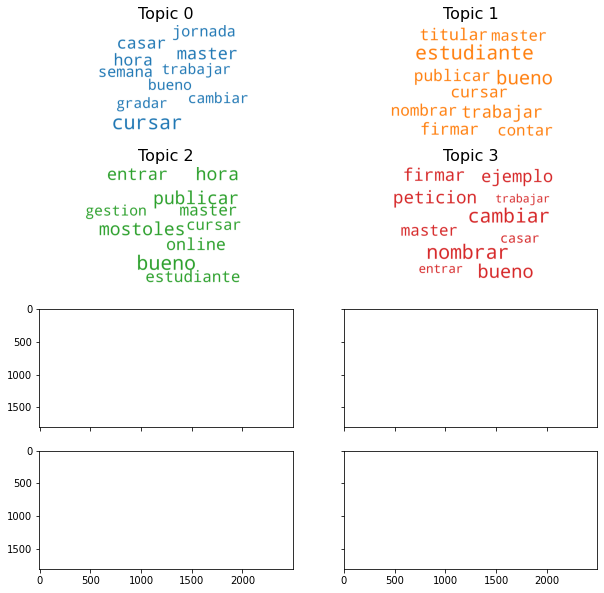

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords = stop_words,
                  background_color = 'white',
                  width = 2500,
                  height = 1800,
                  max_words = 10,
                  colormap = 'tab10',
                  color_func = lambda *args, **kwargs: cols[i],
                  prefer_horizontal = 1.0)

topics = model.show_topics(formatted = False)

fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x = 0, y = 0)
plt.tight_layout()
plt.show()


# Nueva sección

In [ ]:

"""

PRE-PROCESS: 

0. Get the unduplicated / non-retweeted tweets. 


NON-TUNED PRE-PROCESSING STEPS:

1. Remove the hashtags, links and shares

2. Lowcase 

3. Remove punctuation 

4. Remove accents 

5. Remove numbers (TBC)

6. Lemmatise 

7. Make some corrections uncovered above


TUNED STEPS:

8. Remove stopwords (TBC properly) 

9. Remove short tweets 

10. Group by author and gridsearch best LDA hyperparameters.  

"""


# 1. Remove links, hashtags and mentions
# --------------------------------------

def hashtag(txt):
    
    # Remove hashtags
    result = ' '.join(word for word in txt.split(' ') if not word.startswith('#'))
    
    # Remove shares
    result = ' '.join(word for word in result.split(' ') if not word.startswith('@'))
    
    # Remove some jajajas
    result = ' '.join(word for word in result.split(' ') if 'jaja' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'jj' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'haha' not in word.lower())

    # Remove links
    result = re.sub(r'http\S+', '', result)

    # Further work with potential remainings
    result = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", result)
    result = re.sub(r'[¿“‘?’"„“<>,!"]', "", result)
    result = re.sub('!', "", result)
    
    return result

    
data['text'] = data['text'].apply(hashtag)


# 2. Lowcase 
# --------------------------------------

data['text'] = data['text'].apply(np.char.lower)



# 3. Remove punctuation from text
# --------------------------------------

from gensim.parsing.preprocessing import strip_punctuation
data['text'] = data['text'].apply(strip_punctuation)



# 4. Remove accents from text
# --------------------------------------

import unidecode
data['text'] = data['text'].apply(unidecode.unidecode)
data['text'] = data['text'].apply(gensim.utils.deaccent) # In case we apply both 



# 5. Remove numbers
# --------------------------------------

data['text'] = data['text'].str.replace('\d+', '')



# 6. Lemmatisation
# --------------------------------------
# The purpose of this code is to lemmatize (Convert to dictionary form) the words in each document, 
# keeping the same format

nlp = spacy.load('es_core_news_sm', exclude = ['derechos', 'expres', 'ademas', 'traves', 'adios'], disable = ['derechos', 'expres', 'ademas', 'traves', 'adios'])

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

data['lemmatized'] = data['text'].apply(lambda x: lemmatizer(x)) 



# 7. Further cleaning
# --------------------------------------

def corrector(text):     
    text = text.replace(' lumnos ', ' alumno ') 
    text = text.replace(' estudiante ', ' alumno ') # Synonims I think it's worth having them as the same word
    text = text.replace(' avda ', ' avenida ')
    text = text.replace(' info ', ' informacion ')
    text = text.replace(' uni ', ' universidad ')
    text = text.replace(' almerio ', ' almeria ')
    text = text.replace(' estudio ', ' estudiar ')
    text = text.replace(' cambier ', ' cambiar ')
    
    return text

data['lemmatized'] = data['lemmatized'].apply(corrector)

from gensim.parsing.preprocessing import strip_multiple_whitespaces
data['lemmatized'] = data['lemmatized'].apply(strip_multiple_whitespaces)



# 8. Stopwords work 
# --------------------------------------

# Find the list of stopwords

# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
extras = ['seguro', 'realizar', 'titulo', 'clase', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']
